Ngưỡng phân loại (λ): 0.3793


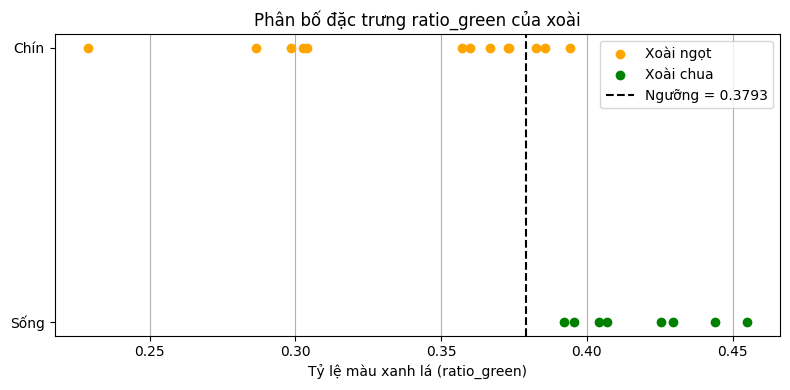

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

# === Đường dẫn dataset (ảnh xoài đã tách nền) ===
base_dir = "/media/pphong/D:/ML & DL/ML/pred_mango/image_tachnen"

# Lưu giá trị ratio_green theo nhãn
green_ratios = {"ngot": [], "chua": []}

# === TÍNH ratio_green CHO TỪNG ẢNH ===
for label in ["ngot", "chua"]:
    folder_path = os.path.join(base_dir, label)
    for fname in os.listdir(folder_path):
        if not fname.lower().endswith(('.jpg', '.png', '.jpeg')):
            continue

        # Đọc ảnh và chuyển sang RGB
        img = Image.open(os.path.join(folder_path, fname)).convert("RGB")
        img_np = np.array(img)

        # Mask để chỉ giữ vùng chứa xoài (loại bỏ nền đen)
        mask = np.any(img_np > [0, 0, 0], axis=-1)

        # Tách 3 kênh màu trong vùng có xoài
        R = img_np[:, :, 0][mask]
        G = img_np[:, :, 1][mask]
        B = img_np[:, :, 2][mask]

        if R.size > 0:
            sumR = np.sum(R)
            sumG = np.sum(G)
            sumB = np.sum(B)
            ratio_green = sumG / (sumR + sumG + sumB)  # theo công thức trong đề
            green_ratios[label].append(ratio_green)

# === TÍNH NGƯỠNG PHÂN LOẠI ===
mean_ngot = np.mean(green_ratios["ngot"])
mean_chua = np.mean(green_ratios["chua"])
lamda = (mean_ngot + mean_chua) / 2

print(f"Ngưỡng phân loại (λ): {lamda:.4f}")

# === VẼ BIỂU ĐỒ ===
plt.figure(figsize=(8,4))
plt.scatter(green_ratios["ngot"], [1]*len(green_ratios["ngot"]),
            color="orange", label="Xoài chín")
plt.scatter(green_ratios["chua"], [0]*len(green_ratios["chua"]),
            color="green", label="Xoài Sống")

plt.axvline(x=lamda, color='black', linestyle='--', label=f'Ngưỡng = {lamda:.4f}')
plt.yticks([0,1], ["Sống","Chín"])
plt.xlabel("Tỷ lệ màu xanh lá (ratio_green)")
plt.title("Phân bố đặc trưng ratio_green của xoài")
plt.legend()
plt.grid(True, axis="x")
plt.tight_layout()
plt.show()
